# La Liga Relevancy - Eduardo Camavinga

### Libraries

In [ ]:
# Numerical Manipulation
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from yellowbrick.model_selection import ValidationCurve
# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
# Extrem Gradient Boosting
from xgboost import XGBRegressor

### Processing Libraries

In [ ]:
# Feature Engineering
from sklearn.base import BaseEstimator, TransformerMixin
# Pipeline, OneHotEncoder & ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
df = pd.read_csv('/work/cama_train.csv')
df.head(10)

,match,competition,date,position,minutes_played,total_actions,total_actions_successful,total_actions_percent,goals,assists,...,aerial_duels,aerial_duels_won,aerial_duels_percent,interceptions,losses,losses_own_half,losses_percent,recoveries,recoveries_opp_half,recoveries_percent
0,Real Madrid - Valencia 5:1,Spain. LaLiga,11/11/23,RCMF,100,90,66,73,0,0,...,1,0,0,2,13,6,46,4,2,50
1,Real Madrid - Sporting Braga 3:0,Europe. UEFA Champions League,11/8/23,RCMF,96,90,55,61,0,0,...,2,2,100,4,11,1,9,9,3,33
2,Real Madrid - Rayo Vallecano 0:0,Spain. LaLiga,11/5/23,"LB, LCMF",88,85,56,66,0,0,...,6,2,33,2,7,2,29,11,5,45
3,Barcelona - Real Madrid 1:2,Spain. LaLiga,10/28/23,LB,45,49,32,65,0,0,...,0,0,0,4,3,1,33,4,3,75
4,Sporting Braga - Real Madrid 1:2,Europe. UEFA Champions League,10/24/23,"LCMF, LW",94,112,83,74,0,0,...,2,1,50,10,5,2,40,10,3,30
5,Sevilla - Real Madrid 1:1,Spain. LaLiga,10/21/23,DMF,32,20,14,70,0,0,...,0,0,0,3,3,2,67,2,1,50
6,Real Madrid - Osasuna 4:0,Spain. LaLiga,10/7/23,LCMF,67,80,61,76,0,0,...,0,0,0,3,9,2,22,3,1,33
7,Napoli - Real Madrid 2:3,Europe. UEFA Champions League,10/3/23,LB,65,58,44,76,0,0,...,0,0,0,3,3,1,33,5,2,40
8,Girona - Real Madrid 0:3,Spain. LaLiga,9/30/23,LB,103,93,67,72,0,0,...,0,0,0,7,10,6,60,9,2,22
9,Real Madrid - Las Palmas 2:0,Spain. LaLiga,9/27/23,"LCMF3, LW",79,76,52,68,0,0,...,1,1,100,4,12,6,50,6,3,50


In [ ]:
df.shape

(105, 39)

In [ ]:
df.isnull().sum()

match                       0
competition                 0
date                        0
position                    0
minutes_played              0
total_actions               0
total_actions_successful    0
total_actions_percent       0
goals                       0
assists                     0
shots                       0
shots_on_target             0
shots_percent               0
xG                          0
passes                      0
passes_accurate             0
passes_percent              0
long_passes                 0
long_passes_accurate        0
long_passes_percent         0
crosses                     0
crosses_accurate            0
crosses_percent             0
dribbles                    0
dribbles_successful         0
dribbles_percent            0
duels                       0
duels_won                   0
duels_percent               0
aerial_duels                0
aerial_duels_won            0
aerial_duels_percent        0
interceptions               0
losses    

## Data Pre-Processing

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

# Columns to drop
columns_to_drop = ['match', 'competition', 'date']

drop_columns_transformer = DropColumns(columns_to_drop)
df = drop_columns_transformer.transform(df)

In [ ]:
class ConvertToFloat(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].astype(float)
        return X

# Columnas to switch on:
columns_to_convert = [
    'total_actions_percent', 'shots_percent', 'passes_percent',
    'long_passes_percent', 'crosses_percent', 'dribbles_percent', 
    'duels_percent', 'aerial_duels_percent', 'losses_percent', 
    'recoveries_percent'
]

# ConvertToFloat Instance
convert_to_float_transformer = ConvertToFloat(columns_to_convert)

df = convert_to_float_transformer.transform(df)

In [ ]:
# class FillMissing(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X.ffill()

# # FillMissing Instance
# fill_missing_transformer = FillMissing()


# df = fill_missing_transformer.transform(df)

## Position Relevancy

In [ ]:
position_counts = df['position'].value_counts()
print(position_counts)

top_three_positions = df['position'].value_counts().head(3)
print(top_three_positions)

# To get the average (mean) frequency of the top 3 positions
mean_top_three = top_three_positions.mean()
print(mean_top_three)

LCMF3           25
DMF             13
LB              12
RCMF3            8
RCMF             6
DMF, LCMF3       5
LCMF             4
DMF, LB          3
LB, LCMF3        3
LB, LCMF         2
DMF, LDMF        2
DMF, LCMF        2
LW               2
LCMF3, RCMF3     1
DMF, LW          1
LCB, RDMF        1
LDMF             1
RDMF             1
LDMF, RCMF       1
LCMF, LW         1
LCMF3, RDMF      1
LB, RDMF         1
LB, LDMF         1
LDMF, RDMF       1
DMF, RCMF        1
DMF, RDMF        1
AMF, LCMF3       1
LCMF3, LW        1
LB, LW           1
DMF, RCMF3       1
LWF              1
Name: position, dtype: int64
LCMF3    25
DMF      13
LB       12
Name: position, dtype: int64
16.666666666666668


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

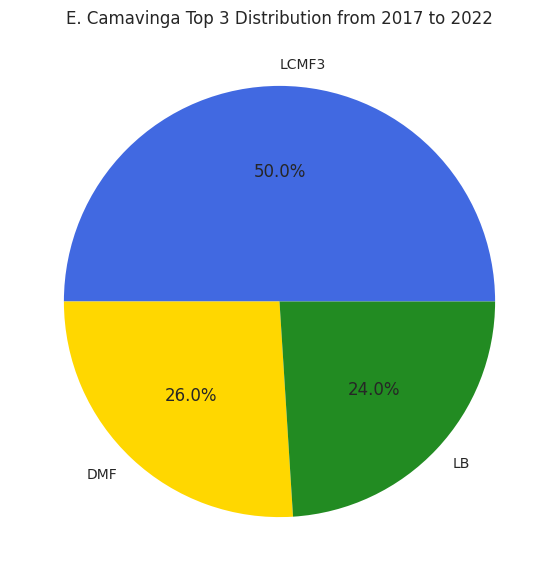

In [ ]:
proportions = top_three_positions / top_three_positions.sum()

colors = ['royalblue', 'gold', 'forestgreen']


plt.figure(figsize=(10,7))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=colors)
plt.title("E. Camavinga Top 3 Distribution from 2017 to 2022")
plt.rcParams['font.family'] = 'Liberation Sans'
plt.show()

findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

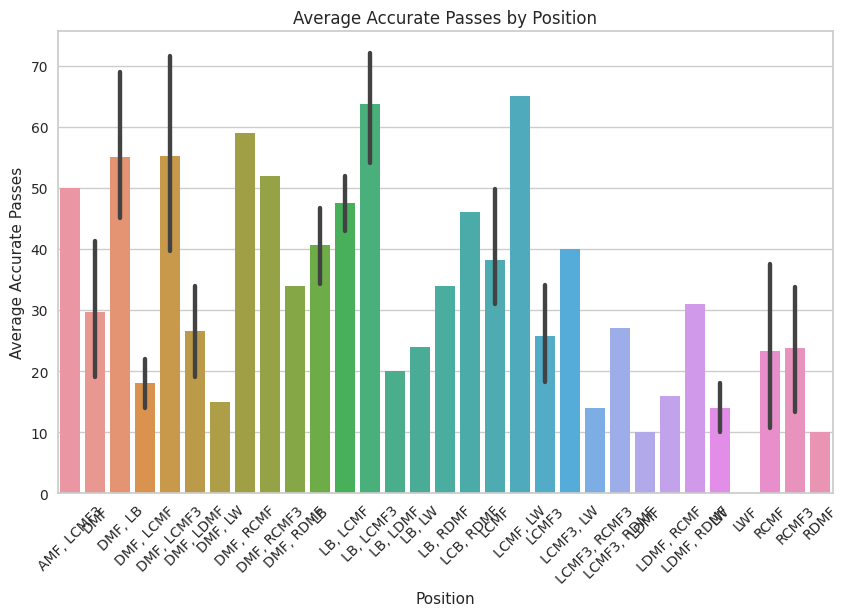

In [ ]:
df['position'] = df['position'].astype('category')  


plt.figure(figsize=(10, 6))  
sns.barplot(x='position', y='passes_accurate', data=df)  

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.title('Average Accurate Passes by Position')  
plt.xlabel('Position')  
plt.ylabel('Average Accurate Passes')  
plt.xticks(rotation=45)  
plt.show()  

## Average Minutes Played

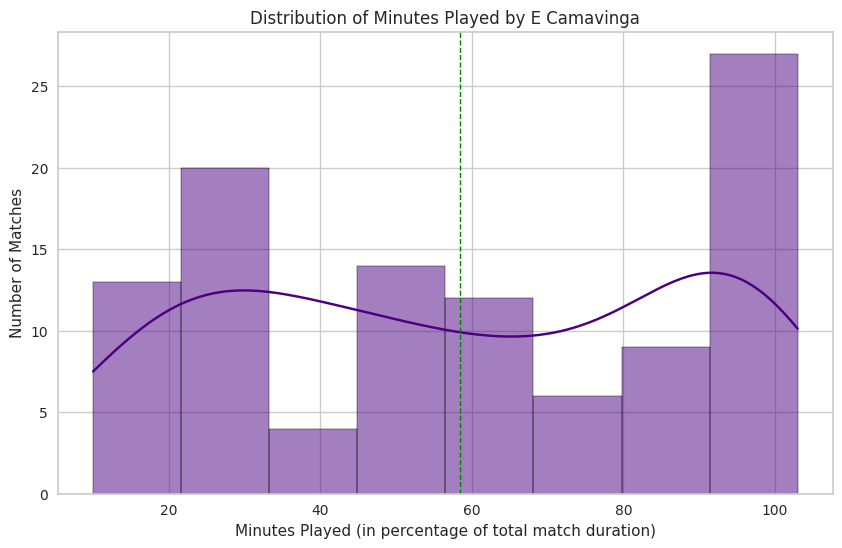

E. camavingas played on average 58.44761904761905 minutes per match.


In [ ]:
average_minutes_played = df['minutes_played'].mean()

# Plot the distribution of minutes played
plt.figure(figsize=(10, 6))
sns.histplot(df['minutes_played'], kde=True, color='indigo')
plt.axvline(average_minutes_played, color='green', linestyle='dashed', linewidth=1)
plt.title('Distribution of Minutes Played by E Camavinga')
plt.xlabel('Minutes Played (in percentage of total match duration)')
plt.ylabel('Number of Matches')
plt.show()

print(f"E. camavingas played on average {average_minutes_played} minutes per match.")

## Interceptions

Dani Ceballos has an average of 2.638095238095238 interceptions per match.
The minimum interceptions in a match by E. Camavinga is 0.
The maximum interceptions in a match by E. Camavinga is 15.


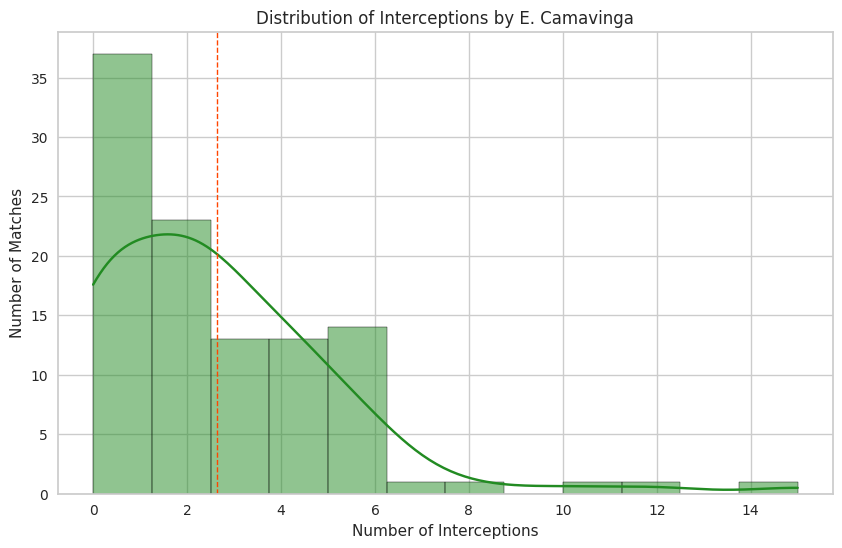

In [ ]:
# Calculate the average interceptions
average_interceptions = df['interceptions'].mean()

# Find the minimum and maximum interceptions
min_interceptions = df['interceptions'].min()
max_interceptions = df['interceptions'].max()

# Print out the results
print(f"Dani Ceballos has an average of {average_interceptions} interceptions per match.")
print(f"The minimum interceptions in a match by E. Camavinga is {min_interceptions}.")
print(f"The maximum interceptions in a match by E. Camavinga is {max_interceptions}.")

# Plot the distribution of interceptions
plt.figure(figsize=(10, 6))
sns.histplot(df['interceptions'], kde=True, color='forestgreen')
plt.axvline(average_interceptions, color='orangered', linestyle='dashed', linewidth=1)
plt.title('Distribution of Interceptions by E. Camavinga')
plt.xlabel('Number of Interceptions')
plt.ylabel('Number of Matches')
plt.show()

# Exploratory Data Analysis

### Pearsons Method Heatmap

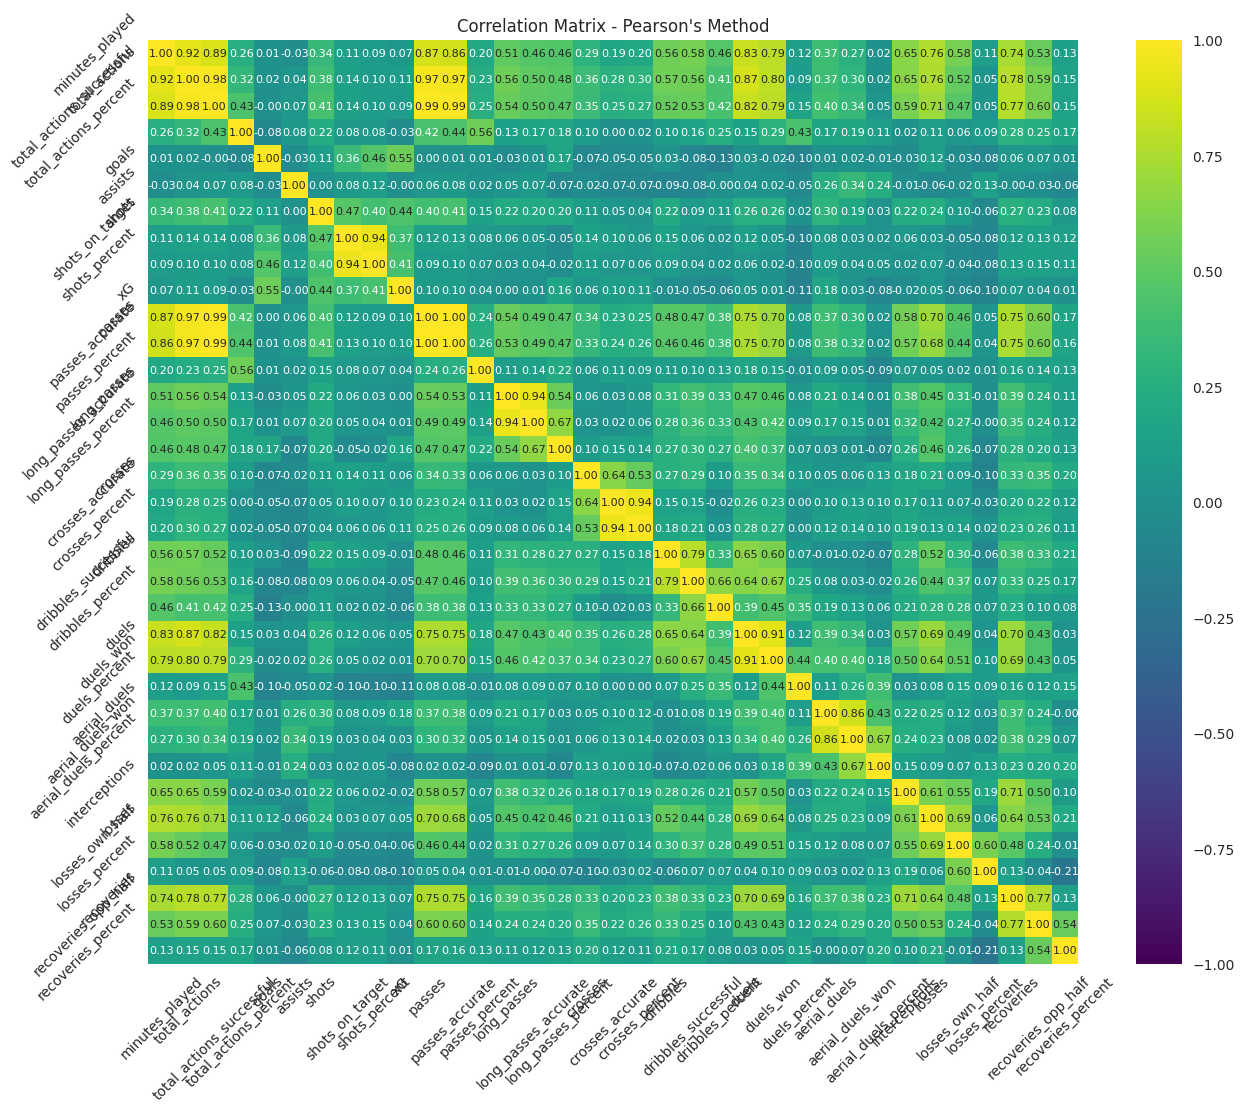

In [ ]:
# Calculating the Pearson correlation matrix
pearson_corr_matrix = df.corr(method='pearson')

# Creating a heatmap with the Pearson correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(pearson_corr_matrix, annot=True, fmt=".2f", cmap='viridis', vmax=1, vmin=-1, annot_kws={"size": 8})
plt.title("Correlation Matrix - Pearson's Method")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Spearman's Method Heatmap

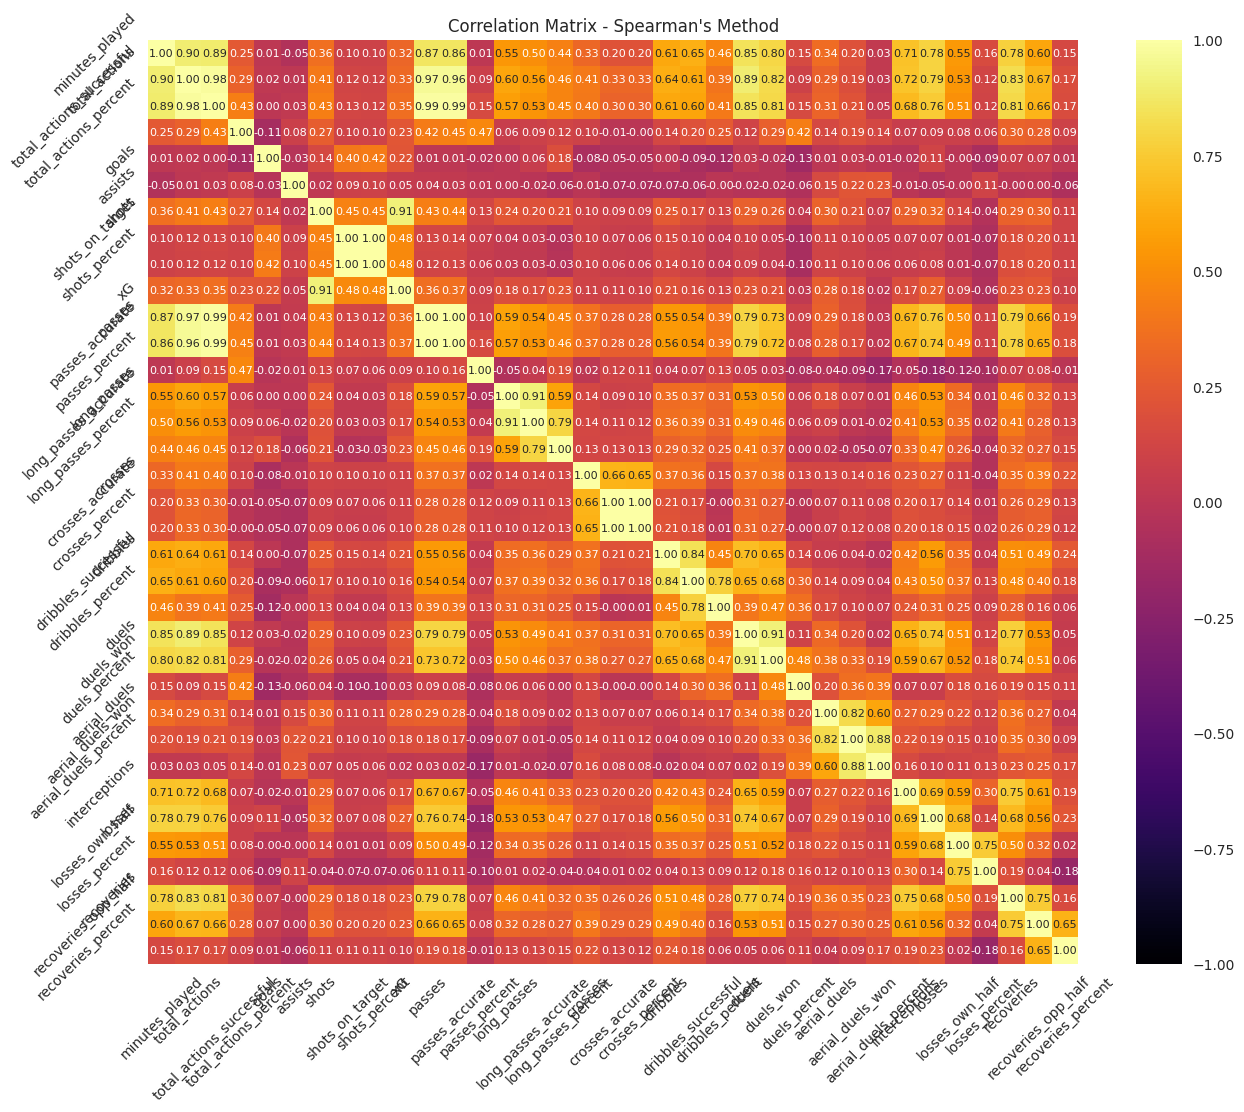

In [ ]:
# Calculating the correlation matrix using Spearman's method
corr_matrix = df.corr(method='spearman')


plt.figure(figsize=(15, 12))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='inferno', vmax=1, vmin=-1, annot_kws={"size": 8}) 

plt.title("Correlation Matrix - Spearman's Method")

plt.xticks(rotation=45)  
plt.yticks(rotation=45)  
plt.show()

### Dispersion Matrix

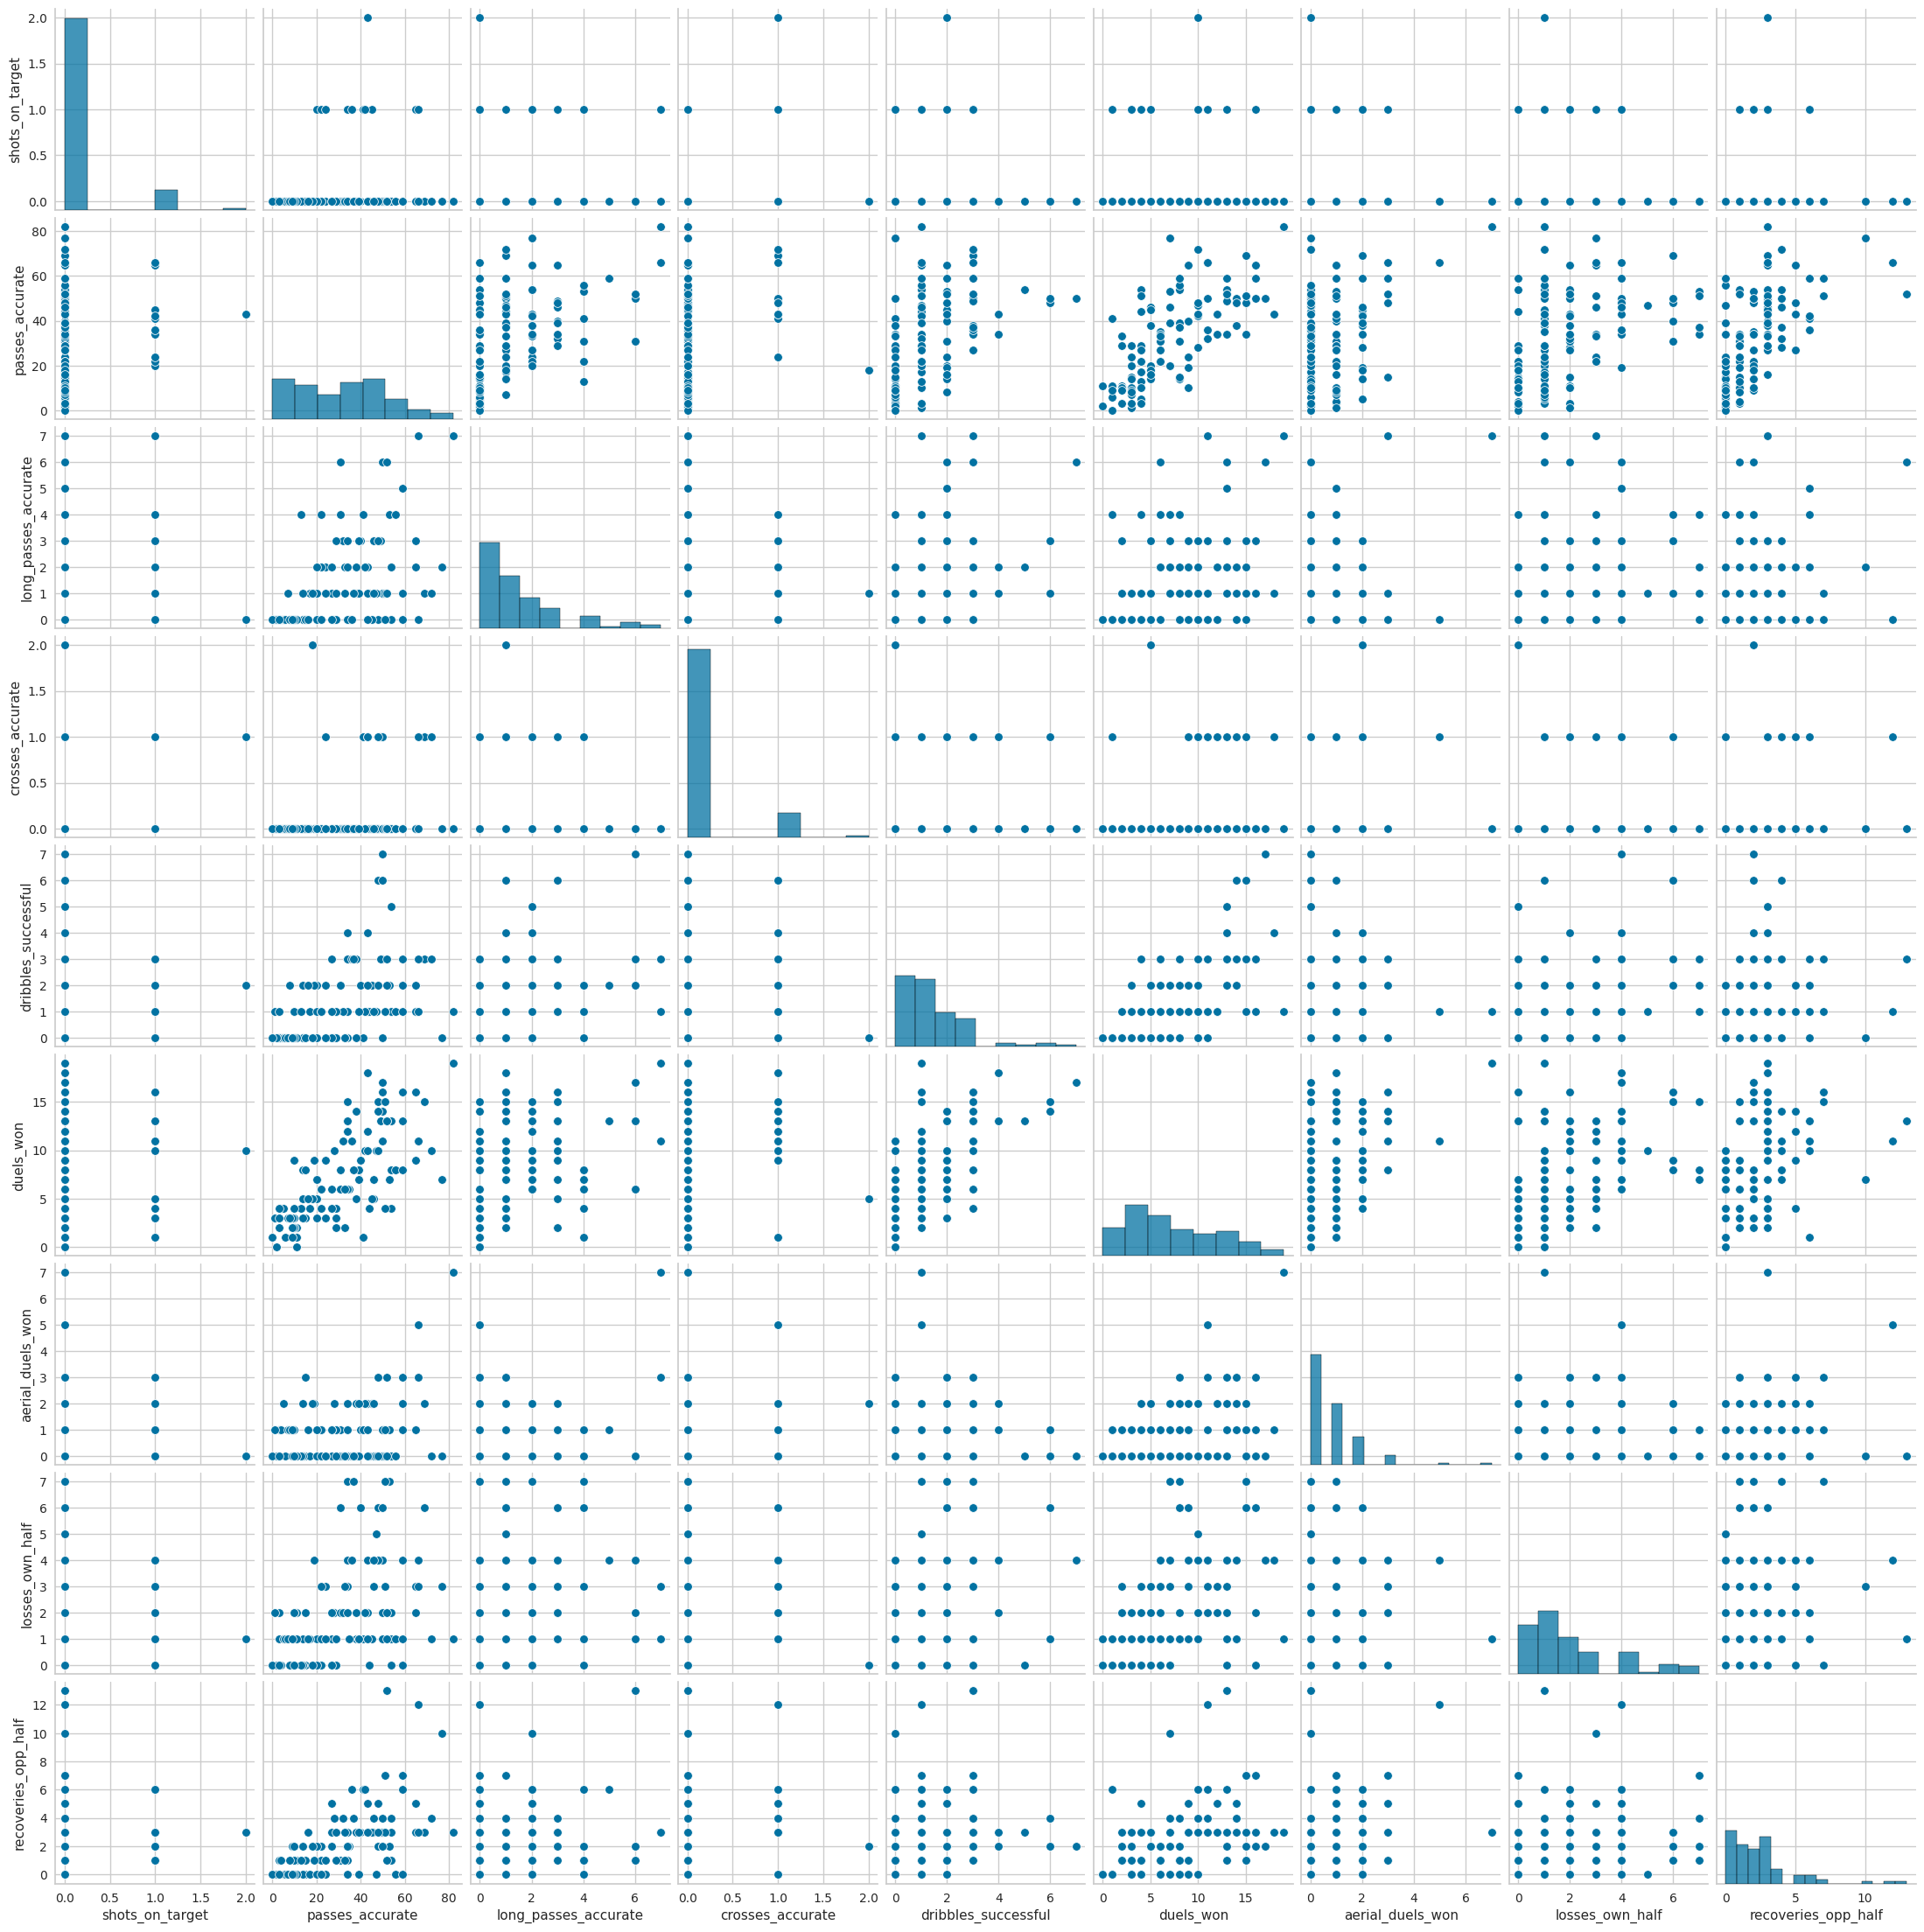

In [ ]:
selected_columns = [
    'shots_on_target', 'passes_accurate', 
    'long_passes_accurate', 'crosses_accurate', 'dribbles_successful', 
    'duels_won', 'aerial_duels_won', 'losses_own_half', 'recoveries_opp_half'
]
subset_df = df[selected_columns]

# Dispersion Matrix (PairPlot)
sns.pairplot(subset_df, diag_kind='hist')

plt.show()

### One-Hot Encoding on Position

In [ ]:
# Applying OneHotEncoding
column_to_encode = ['position']

# Building Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), column_to_encode)
    ],
    remainder='passthrough'  # Mantener el resto de las columnas sin cambios
)

# Applying on DataFrame
transformed_data = preprocessor.fit_transform(df)

new_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(column_to_encode)
all_columns = list(new_columns) + [col for col in df.columns if col not in column_to_encode]


df = pd.DataFrame(transformed_data, columns=all_columns)

In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(df[col])):
        print(f"Infinites found in {col}")

# Applying Feature Engineering

In [ ]:
df.head(5)

,"position_AMF, LCMF3",position_DMF,"position_DMF, LB","position_DMF, LCMF","position_DMF, LCMF3","position_DMF, LDMF","position_DMF, LW","position_DMF, RCMF","position_DMF, RCMF3","position_DMF, RDMF",...,aerial_duels,aerial_duels_won,aerial_duels_percent,interceptions,losses,losses_own_half,losses_percent,recoveries,recoveries_opp_half,recoveries_percent
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,13.0,6.0,46.0,4.0,2.0,50.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,100.0,4.0,11.0,1.0,9.0,9.0,3.0,33.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,33.0,2.0,7.0,2.0,29.0,11.0,5.0,45.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,3.0,1.0,33.0,4.0,3.0,75.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,50.0,10.0,5.0,2.0,40.0,10.0,3.0,30.0


### Step - 1 (Setting New Features)

In [ ]:
# To prevent division by zero, we replace zeros with a small value before performing divisions
df['recoveries'] = df['recoveries'].replace(0, 0.01)
df['duels_won'] = df['duels_won'].replace(0, 0.01)
df['passes'] = df['passes'].replace(0, 0.01)
df['dribbles'] = df['dribbles'].replace(0, 0.01)
df['passes_accurate'] = df['passes_accurate'].replace(0, 0.01)
df['long_passes_accurate'] = df['long_passes_accurate'].replace(0, 0.01)

# Creating new features based on interactions between existing metrics
df['recoveries_passes_ratio'] = df['recoveries'] / df['passes']
df['recoveries_duels_won_ratio'] = df['recoveries'] / df['duels_won']
df['duels_won_passes_ratio'] = df['duels_won'] / df['passes']
df['dribbles_passes_ratio'] = df['dribbles'] / df['passes']
df['accurate_passes_long_passes_ratio'] = df['passes_accurate'] / df['long_passes_accurate']


In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(df[col])):
        print(f"Infinites found in {col}")

### Step - 2 (Imputing Process)

In [ ]:
from sklearn.impute import SimpleImputer

# Invoking & storage theSimpleImputer
imputer = SimpleImputer(strategy='median')
# Applying on DataFrame
df_imputed = imputer.fit_transform(df)

# Setting the DataFrame
df = pd.DataFrame(df_imputed, columns=df.columns)

- Feature Engineering Verification

In [ ]:
# Checking Changes
print(df.head())

   position_AMF, LCMF3  position_DMF  position_DMF, LB  position_DMF, LCMF  \
0                  0.0           0.0               0.0                 0.0   
1                  0.0           0.0               0.0                 0.0   
2                  0.0           0.0               0.0                 0.0   
3                  0.0           0.0               0.0                 0.0   
4                  0.0           0.0               0.0                 0.0   

   position_DMF, LCMF3  position_DMF, LDMF  position_DMF, LW  \
0                  0.0                 0.0               0.0   
1                  0.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   

   position_DMF, RCMF  position_DMF, RCMF3  position_DMF, RDMF  ...  \
0                 0.0                  0.0                 0.0  ...   
1   

# Machine Learning Models

- Infinite Handler Function

In [ ]:
# Creating a custom transformer to handle infinite values
def replace_inf(X):
    X = np.where(np.isinf(X), np.nan, X)
    return X

### Random Forest with Scikit-Learn

In [ ]:
from sklearn.ensemble import RandomForestRegressor

target = 'passes'

# Splitting the dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Best parameters:  {'regressor__max_depth': 10, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best score (negative MSE):  -7.849101651143966


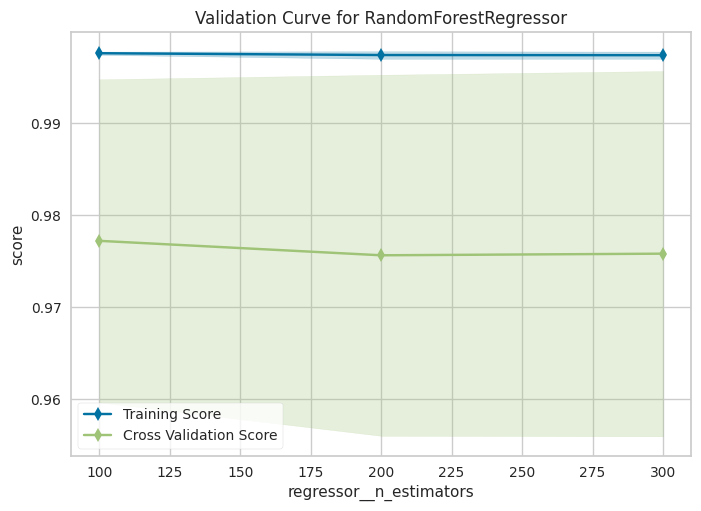

In [ ]:
# Building the pipeline
pipeline = Pipeline([
    ('handle_inf', FunctionTransformer(replace_inf, validate=False)),  # Handle infinite values
    ('imputer', SimpleImputer(strategy='median')),     # Impute missing values
    ('regressor', RandomForestRegressor(random_state=42))   # Regressor - Random Forest
])

# Define the hyperparameter space for grid search
param_grid = {
    'regressor__n_estimators': [200, 300, 500],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt'],
    # 'regressor__bootstrap': [True, False]  # Optional
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


# Best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score (negative MSE): ", grid_search.best_score_)

# Validation curves with Yellowbrick
val_curve = ValidationCurve(
    pipeline, param_name="regressor__n_estimators",  # Model and parameter to vary
    param_range=[100, 200, 300], cv=5, scoring="r2"  # Range of parameter values and scoring metric
)
val_curve.fit(X_train, y_train)  # Fitting the model
val_curve.show()  # Display the validation curve
plt.show()

### Checking on Parameters

In [ ]:
# Define the model with the best hyperparameters identified from GridSearchCV
best_model = RandomForestRegressor(
    max_depth=10,
    max_features='auto',  
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42  
)

# Train the model using the full training set
best_model.fit(X_train, y_train)

# Evaluate the model using the test set
r2_score = best_model.score(X_test, y_test)
print(f'R^2 score on the test set: {r2_score}')

R^2 score on the test set: 0.9793758726777559


R^2 score on the test set: 0.9793758726777559
Mean Squared Error on the test set: 11.10987902390401


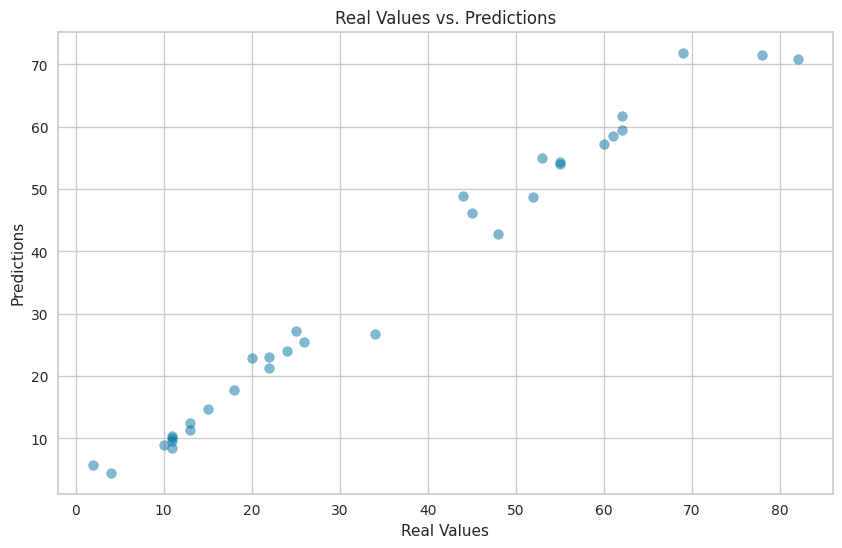

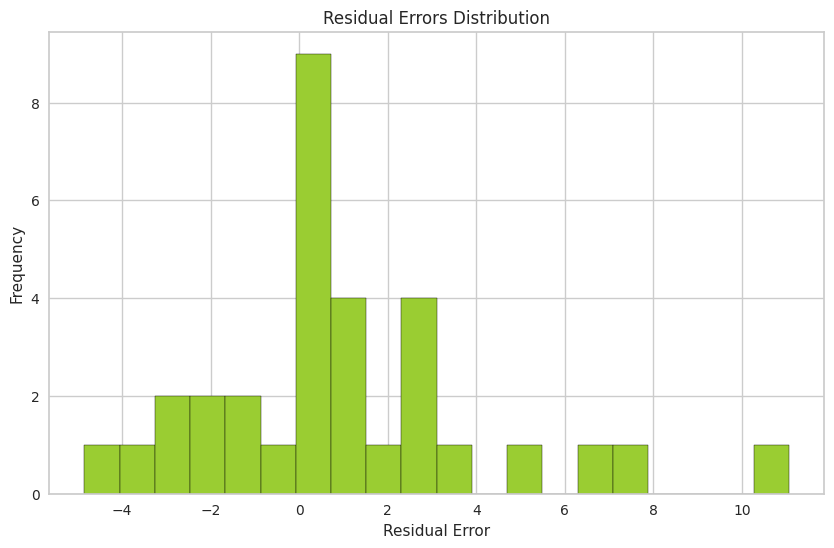

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

target = 'passes'

# Splitting the dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Model Training
best_model = RandomForestRegressor(
    max_depth=10,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

best_model.fit(X_train, y_train)

# Model Evaluation
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R^2 score on the test set: {r2}')
print(f'Mean Squared Error on the test set: {mse}')

# Model Visulization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Real Values vs. Predictions')
plt.show()

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.hist(residuals, bins=20, color='yellowgreen',edgecolor='black')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.title('Residual Errors Distribution')
plt.show()

### XGBoost 

In [ ]:
# DataFrame Mandatory Copy
dfx = df.copy()
dfx.head(10)

,"position_AMF, LCMF3",position_DMF,"position_DMF, LB","position_DMF, LCMF","position_DMF, LCMF3","position_DMF, LDMF","position_DMF, LW","position_DMF, RCMF","position_DMF, RCMF3","position_DMF, RDMF",...,losses_own_half,losses_percent,recoveries,recoveries_opp_half,recoveries_percent,recoveries_passes_ratio,recoveries_duels_won_ratio,duels_won_passes_ratio,dribbles_passes_ratio,accurate_passes_long_passes_ratio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,46.0,4.0,2.0,50.0,0.072727,0.266667,0.272727,0.127273,16.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,9.0,9.0,3.0,33.0,0.204545,0.642857,0.318182,0.181818,19.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,29.0,11.0,5.0,45.0,0.224490,0.916667,0.244898,0.061224,21.500000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,33.0,4.0,3.0,75.0,0.148148,1.000000,0.148148,0.185185,27.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,40.0,10.0,3.0,30.0,0.144928,0.625000,0.231884,0.028986,21.666667
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,67.0,2.0,1.0,50.0,0.153846,1.000000,0.153846,0.000769,1100.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,22.0,3.0,1.0,33.0,0.050000,0.750000,0.066667,0.050000,5400.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,33.0,5.0,2.0,40.0,0.138889,0.833333,0.166667,0.111111,3500.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,60.0,9.0,2.0,22.0,0.173077,0.562500,0.307692,0.096154,50.000000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,50.0,6.0,3.0,50.0,0.125000,0.666667,0.187500,0.083333,13.333333


In [ ]:
from sklearn.model_selection import train_test_split

# Setting New DataFrame
X = dfx.drop('passes', axis=1)
y = dfx['passes']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
from xgboost import XGBRegressor

# Configuración del pipeline
pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror'))
])

- Looking for the best parameters:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Configuration of parameters for search
# parameters = {
#     'xgb__max_depth': [3, 5, 7],
#     'xgb__learning_rate': [0.01, 0.1, 0.3],
#     # Other parameters
# }

parameters = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [1, 1.5, 2]
}


grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)

# Extracting the best score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 300, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}
Best Score: 0.9745312067192528


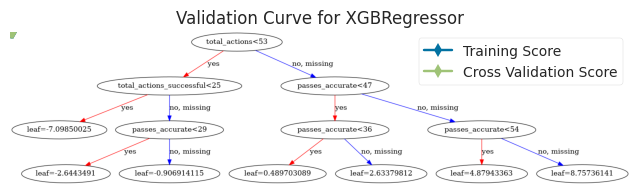

In [ ]:
from yellowbrick.model_selection import ValidationCurve
import xgboost as xgb

# Visualization of the tree
xgb.plot_tree(grid_search.best_estimator_['xgb'], num_trees=0)

# Validation Curve
viz = ValidationCurve(
    XGBRegressor(objective='reg:squarederror'), param_name="max_depth",
    param_range=[3, 5, 7], cv=3, scoring="r2"
)
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

MSE: 10.649747620651372
R^2: 0.9802300501737689


- Last Optimized Forest

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Rebuilding the model with the identified best hyperparameters
optimized_pipeline = Pipeline([
    ('xgb', XGBRegressor(
        objective='reg:squarederror', 
        learning_rate=0.3, 
        max_depth=3,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        min_child_weight=1,
        reg_alpha=0.1,
        reg_lambda=1
    ))
])

# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Predicting on the test data
y_pred = optimized_pipeline.predict(X_test)

# Evaluating the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 10.649747620651372
R^2 Score: 0.9802300501737689


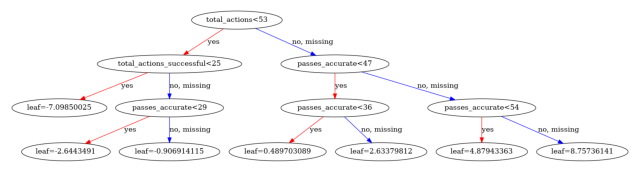

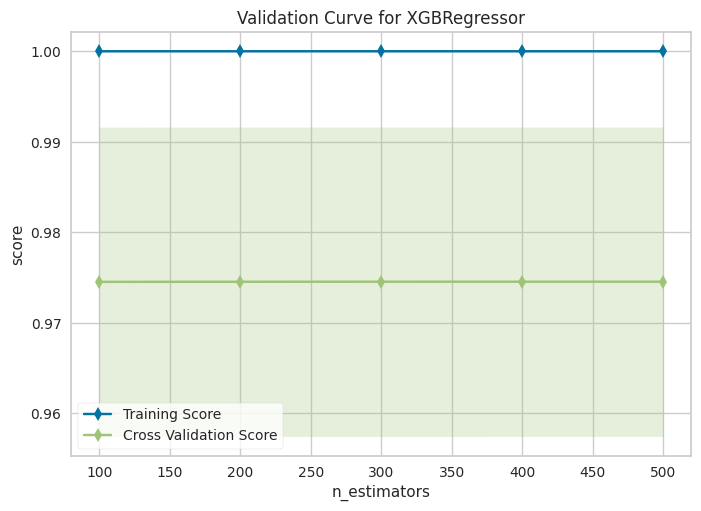

In [ ]:
import xgboost as xgb
from yellowbrick.model_selection import ValidationCurve

# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Visualizing the first tree of the model
xgb_model = optimized_pipeline.named_steps['xgb']
xgb.plot_tree(xgb_model, num_trees=0)
plt.show()

# Creating a Validation Curve
viz = ValidationCurve(
    XGBRegressor(
        objective='reg:squarederror', 
        learning_rate=0.3, 
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        min_child_weight=1,
        reg_alpha=0.1,
        reg_lambda=1
    ),
    param_name="n_estimators",
    param_range=[100, 200, 300, 400, 500],  # Adjust this range based on your needs
    cv=3,
    scoring="r2"
)

viz.fit(X_train, y_train)
viz.show()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daef11ba-c0db-4c7e-befd-074ae55470e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>